In [3]:
%load_ext autoreload
%autoreload 2
from custom.model import FreeConvNetwork
from torchsummary import summary
import torch

# Testing & summarizeing the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = FreeConvNetwork().to(device)

summary(model, (3, 218, 178))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
LocallyConnected2d-1           [-1, 32, 54, 44]       8,287,488
              ReLU-2           [-1, 32, 54, 44]               0
LocallyConnected2d-3           [-1, 64, 13, 10]       9,592,960
              ReLU-4           [-1, 64, 13, 10]               0
         MaxPool2d-5             [-1, 64, 6, 5]               0
           Flatten-6                 [-1, 1920]               0
            Linear-7                  [-1, 300]         576,300
              ReLU-8                  [-1, 300]               0
            Linear-9                  [-1, 200]          60,200
Total params: 18,516,948
Trainable params: 18,516,948
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.44
Forward/backward pass size (MB): 1.32
Params size (MB): 70.64
Estimated Total Size (MB): 72.40
-----------------------------------

In [1]:
%load_ext autoreload
%autoreload 2
from utils.create_train_test_folder_structure import create_train_test_folder_structure
import os
create_train_test_folder_structure(200, os.getcwd())


File Not Found: 000041
File Not Found: 000050
File Not Found: 008043
File Not Found: 022306
File Not Found: 022772
File Not Found: 028317
File Not Found: 031243
File Not Found: 041998
File Not Found: 042480
File Not Found: 046478
File Not Found: 046512
File Not Found: 047443
File Not Found: 051028
File Not Found: 055316
File Not Found: 056333
File Not Found: 092550
File Not Found: 095758
File Not Found: 099375
File Not Found: 106632
File Not Found: 110562
File Not Found: 144575
File Not Found: 156287
File Not Found: 000038
File Not Found: 000082
File Not Found: 004213
File Not Found: 006458
File Not Found: 009169
File Not Found: 016664
File Not Found: 023617
File Not Found: 024662
File Not Found: 030967
File Not Found: 032277
File Not Found: 041403
File Not Found: 052520
File Not Found: 054621
File Not Found: 056344
File Not Found: 076227
File Not Found: 089389
File Not Found: 089441
File Not Found: 090328
File Not Found: 091232
File Not Found: 101833
File Not Found: 103127
File Not Fo

In [1]:
from torchvision import datasets,transforms
from sklearn.model_selection import StratifiedShuffleSplit
import torch

transform = transforms.Compose(
    [transforms.ToTensor()]
)

dataset = datasets.ImageFolder("./Data/img_align_celeba/class_data/", transform=transform)

#list all the labels in assigned to the dataset by the ImageFolder method
labels = [label for _, label in dataset]

#make a train/test split from based on the labels using StratifiedShuffleSplit to make sure all labels are evenly represented
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2)
train_indices, test_indices = next(splitter.split(dataset, labels))

train_dataset = torch.utils.data.Subset(dataset, train_indices)
test_dataset = torch.utils.data.Subset(dataset, test_indices)

#define the dataset loader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4)

#report split sizes
print("Training set size: {}".format(len(train_dataset)))
print("Testing set size: {}".format(len(test_dataset)))

Training set size: 4002
Testing set size: 1001


In [25]:
model = FreeConvNetwork().to(device)

for inputs, labels in train_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    voutputs = model(inputs)
    vloss = loss_fn(voutputs, labels)
    break


In [28]:
vloss

tensor(87.1072, device='cuda:0', grad_fn=<NllLossBackward0>)

In [3]:
import torch.nn as nn
import torch
from custom.model import FreeConvNetwork
import torch

#moving model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FreeConvNetwork().to(device)

#defining the loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


In [4]:
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter

def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(train_loader):
        # Every data instance is an input + label pair
        inputs, labels = data
        
        # moving the training data batch by batch to the GPU
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(train_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

In [5]:
# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 100

best_vloss = 1_000_000.

if not os.path.isdir("./model"):
    os.makedirs("./model")

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)

    # We don't need gradients on to do reporting
    model.train(False)

    running_vloss = 0.0
    for i, vdata in enumerate(test_loader):
        vinputs, vlabels = vdata
         
        # moving the test data batch by batch to the GPU
        vinputs, vlabels = vinputs.to(device), vlabels.to(device)
        
        # validating the model
        voutputs = model(vinputs)
        vloss = loss_fn(voutputs, vlabels)
        running_vloss += vloss.detach() # wihtout .detach I get an out of memory error on GPU


    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model/model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)

    epoch_number += 1

EPOCH 1:
  batch 1000 loss: 42.62511813783646
LOSS train 42.62511813783646 valid 5.295729160308838
EPOCH 2:
  batch 1000 loss: 5.293984971046448
LOSS train 5.293984971046448 valid 5.292689323425293
EPOCH 3:
  batch 1000 loss: 5.29571688079834
LOSS train 5.29571688079834 valid 5.289970397949219
EPOCH 4:
  batch 1000 loss: 5.288660575151443
LOSS train 5.288660575151443 valid 5.287445068359375
EPOCH 5:
  batch 1000 loss: 5.286333302021027
LOSS train 5.286333302021027 valid 5.285190582275391
EPOCH 6:
  batch 1000 loss: 5.2841984014511105
LOSS train 5.2841984014511105 valid 5.283097743988037
EPOCH 7:
  batch 1000 loss: 5.282272078990936
LOSS train 5.282272078990936 valid 5.2812066078186035
EPOCH 8:
  batch 1000 loss: 5.28048387670517
LOSS train 5.28048387670517 valid 5.279455184936523
EPOCH 9:
  batch 1000 loss: 5.278848528385162
LOSS train 5.278848528385162 valid 5.27784538269043
EPOCH 10:
  batch 1000 loss: 5.277346254825592
LOSS train 5.277346254825592 valid 5.276369571685791
EPOCH 11:
 

In [9]:
from custom.model import FreeConvNetwork

#correct vs total classifications 
correct = 0
total = 0

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#load the model
model = FreeConvNetwork()
model.load_state_dict(torch.load("./model/model_20230526_155035_99"))
model.to(device)
print(model.eval())

#predict the test labels
with torch.no_grad():
    for input, labels in test_loader:
        input, labels = input.to(device), labels.to(device)
        outputs = model(input)
        _, predicted = torch.max(outputs.data,1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print("Accuracy of the network: %f%%" % (100 * correct/total)) 

FreeConvNetwork(
  (freeConvStack): Sequential(
    (0): LocallyConnected2d()
    (1): ReLU()
    (2): LocallyConnected2d()
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Flatten(start_dim=1, end_dim=-1)
    (6): Linear(in_features=1920, out_features=300, bias=True)
    (7): ReLU()
    (8): Linear(in_features=300, out_features=200, bias=True)
  )
)
Accuracy of the network: 0.599401%


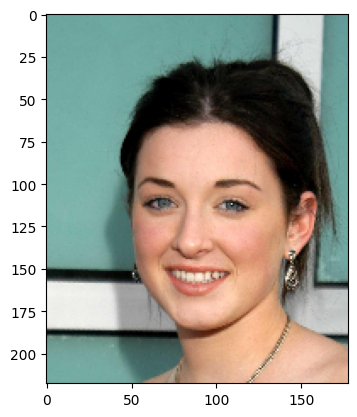

In [31]:
import matplotlib.pyplot as plt

input_image = next(iter(test_loader))[0]
plt.imshow(input_image[0,:,:,:].permute(1,2,0))
plt.show()



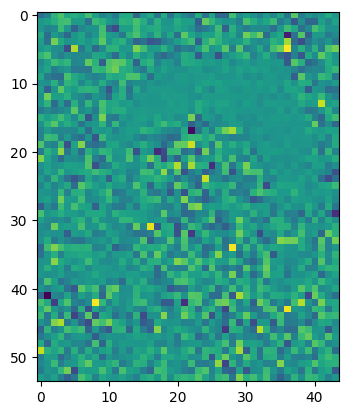

In [58]:

feature_map = next(iter(model.children()))[0](input_image.to(device))

feature_map = feature_map[0,:,:,:]

plt.imshow(feature_map[0,:,:].cpu().detach())